In [4]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

from PIL import Image
import sys
from pathlib import Path
from PIL import Image
import torch
import numpy as np
from molmo_utils import load_model, do_inference, get_coordinates, calculate_probability_of_coordinates
from utils import extract_all, plot_scatter, calculate_normalized_euclidian_distance, visualize_points_on_image, calculate_spread, calculate_all_clusters, show_all_clusters

2025-03-10 18:30:26.861205: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 18:30:27.454840: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-10 18:30:27.454887: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-10 18:30:27.454917: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 18:30:27.472385: I tensorflow/core/platform/cpu_feature_g

In [5]:
model_name = 'allenai/Molmo-7B-D-0924'
model, processor = load_model(model_name)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [11]:
import string
import torch
import matplotlib.pyplot as plt
import random


def create_vqa_prompt(coordinates, task, object, width, height):
    choices = list(string.ascii_lowercase)
    choices_string = ", ".join(choices[:len(coordinates)])
    prompt_coordinates = ""
    for i in range(len(coordinates)):
        prompt_coordinates += f"{choices[i]}: {coordinates[i]}, "
    prompt_coordinates = prompt_coordinates[:-2]

    prompt_start = "You are shown a robotic setting. Your mission is to pick up the following object: "
    prompt_middle = f". You have to choose one out of {len(coordinates)} coordinates, to point to the object. The format of the possible answers looks like this: a: (x1, y1), b: (x2, y2), ... with (x1, y1) and (x2, y2) beeing the coordinates to choose from. The width of the image is {width} pixels and the height of the image is {height} pixels. The coordinates from which you have to choose are the following: "
    
    prompt_end = f". Your output should be the letter of the best answer out of the choices: {choices_string}. Do not use whitespace before or after the letter. Do not output anything else."
    return prompt_start + object + prompt_middle + prompt_coordinates + prompt_end

def get_top_probability_distribution(output_char, output, inputs, tokenizer, top_k=10):
    softmax_fn = torch.nn.Softmax(dim=-1)

    logits = output.logits
    generated_logits = torch.cat(logits, dim=0)
    generated_tokens = output.sequences[0, inputs['input_ids'].size(1):]
    
    answer_token = generated_tokens[0]
    answer_logits = generated_logits[0]
    
    probs = softmax_fn(answer_logits.squeeze(0))
    
    token_prob = probs[answer_token].item()
    
    top_probs, top_indices = torch.topk(probs, top_k)
    top_tokens = [(tokenizer.decode([idx]), top_probs[i].item()) for i, idx in enumerate(top_indices)]

    return token_prob, top_tokens

def do_vqa(coordinates, task, object, image, model, processor, temperature):
    width = image.width
    height = image.height
    prompt = create_vqa_prompt(coordinates, task, object, width, height)
    #print(f"Prompt: {prompt}")
    output_text, output, inputs = do_inference(image, prompt, model, processor, temperature)
    return output_text, output, inputs

def visualize_vqa(image, tokens, probs, coordinates, title="VQA"):
    sorted_coordinates = sort_coordinates_by_letters(tokens, coordinates)

    plt.imshow(image, alpha=1)
    image_width, image_height = image.size

    for prob, token, coordinate in zip(probs, tokens, sorted_coordinates):
        # Extract and plot the points
        x_coords = [x for x, y in [coordinate]]
        y_coords = [y for x, y in [coordinate]]
        label = f"{prob:.4f} ({token})"
        plt.scatter(x_coords, y_coords, marker='o', label=label)
    
    # Add labels and show the plot
    plt.title(title)
    plt.legend(loc="lower right")
    plt.axis("on")  # Show axes
    plt.show()
    plt.close()

def sort_coordinates_by_letters(letters, coordinates):
    """
    Sorts the list of coordinates based on the order of the permuted letter list.
    
    :param letters: List of unique lowercase letters (permutation of 'a' to some letter).
    :param coordinates: List of coordinates corresponding to the letters.
    :return: Sorted list of coordinates based on the sorted order of letters.
    """
    letters = [letter.strip() for letter in letters]
    
    expected_letters = [chr(i) for i in range(ord('a'), ord('a') + len(coordinates))]
    if sorted(letters) != expected_letters:
        raise ValueError(f"The letters list must contain a contiguous sequence from 'a' to '{expected_letters[-1]}'")
        
    letter_to_index = {letter: i for i, letter in enumerate(expected_letters)}
    sorted_coordinates = [coordinates[letter_to_index[letter]] for letter in letters]
    return sorted_coordinates

def run_experiment_vqa(task, object, coordinates, image, model, processor, RUNS = 10):
    summed_probs = {coord: 0 for coord in coordinates}
    for i in range(RUNS):
        shuffled = random.sample(coordinates, len(coordinates))
        
        output_text, output, inputs = do_vqa(shuffled, task, object, image, model, processor, 0.2)
        
        token_prob, top_tokens= get_top_probability_distribution(output_text, output, inputs, processor.tokenizer, len(coordinates))
        for token, prob in top_tokens:
            #print(f"{token}: {prob:.4f}")
            summed_probs[shuffled[ord(token.strip()) - ord('a')]] += prob
            
    average_probs = [ prob / RUNS for coord, prob in summed_probs.items() ]
    visualize_vqa(image, list(string.ascii_lowercase[:len(coordinates)]), average_probs, coordinates, title=object)

In [12]:
def run_experiment_vqa_with_clustering(path_to_experiments, prompt_starts, runs_per_task, temperature, epsilon, min_samples):
    tasks, images, ground_truths, objects = extract_all(path_to_experiments)
    prompt_end = " Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the relevant object. Dont output anything else."
    softmax_fn = torch.nn.Softmax(dim=-1)
    labels = []

    coordinates = [[],[]]

    distances = [[],[]]
    
    spreads = [[],[]]

    diameters = [[],[]]

    majority_size_rates = [[],[]]


    #probs = [[],[]]
    
    for i in range(len(tasks)):
        prompts = []
        task = tasks[i]
        labels.append(task)
        ground_truth = ground_truths[i]

        objects_of_task = objects[i]
        prompts_what = []
        for prompt_start in prompt_starts:
            prompt = prompt_start + task + "For that you have to point to the object in the picture that has to be moved." + prompt_end
            prompts_what.append(prompt)

        prompts.append(prompts_what)


        print(f"{task}")
        with Image.open(images[i]) as image:
            image_width = image.width
            image_height = image.height
    
            if (len(ground_truth) == 2):
                prompts_where = []
                for prompt_start in prompt_starts:
                    prompt = prompt_start + task + "For that you have to point to the place in the picture where the object has to be moved to." +  prompt_end
                    prompts_where.append(prompt)
                labels.append(task)
                prompts.append(prompts_where)
    
            for k in range(1):
                task_coordinates = []
                task_distances = []
                #probabilities = []

                for prompt in prompts[k]:
                    for j in range(runs_per_task):
                        output_text, output, inputs = do_inference(image, prompt, model, processor, temperature)                    
                        coords = get_coordinates(output_text, image_width, image_height)
                        if(coords[0] < 0 or coords[0] < 0):
                            continue
                        
                        norm_dist = calculate_normalized_euclidian_distance(coords, ground_truth[k], image_width, image_height)
                        task_coordinates.append(coords)
                        task_distances.append(norm_dist)
                        #probabilities.append(calculate_probability_of_coordinates(output, inputs, processor))
                    coordinates[k].append(task_coordinates)
                            
    
                n_clusters, index_majority_cluster, cluster_points, noisy_points, centroids, diameters_of_clusters = calculate_all_clusters(task_coordinates, epsilon=epsilon, min_samples=min_samples)
                if (n_clusters != 0):
                    norm_dist = calculate_normalized_euclidian_distance(centroids[index_majority_cluster], ground_truth[k], image_width, image_height)
                    distances[k].append(norm_dist)
                    spreads[k].append(calculate_spread(task_coordinates, image_width, image_height))
                    diameters[k].append(diameters_of_clusters[index_majority_cluster])
                    majority_size_rates[k].append(len(cluster_points[index_majority_cluster]) / len(task_coordinates))
                    #probs[k].append(np.mean(probabilities))
                    show_all_clusters(image, index_majority_cluster, cluster_points, noisy_points, centroids, diameters_of_clusters)

                    vqa_coordinates = [(int(x), int(y)) for x, y in np.vstack((centroids, noisy_points[:2]))]
                    run_experiment_vqa(task, objects_of_task[k], vqa_coordinates, image, model, processor, 10)
                else:
                    visualize_points_on_image(image, ["predictions"], [task_coordinates], object)
                    

                print("")

    return coordinates, distances, spreads, diameters, majority_size_rates#, probs

pick up the wooden block and place it on top of the arch.


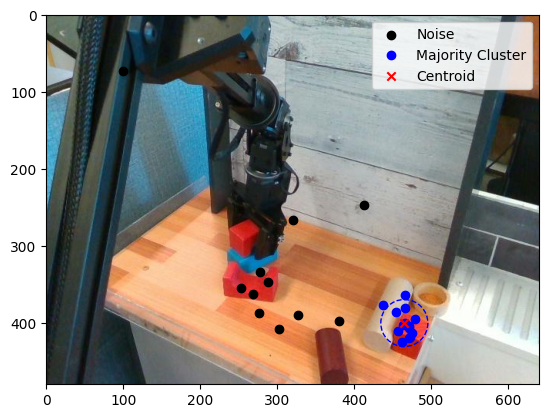

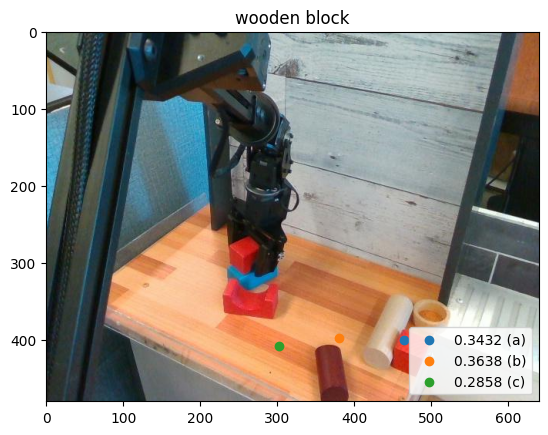


pick up fruit and put it on the table.


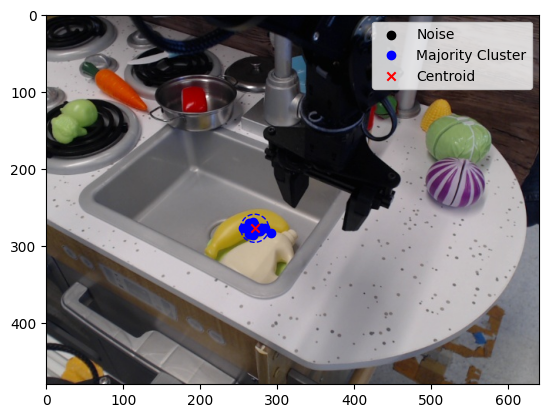

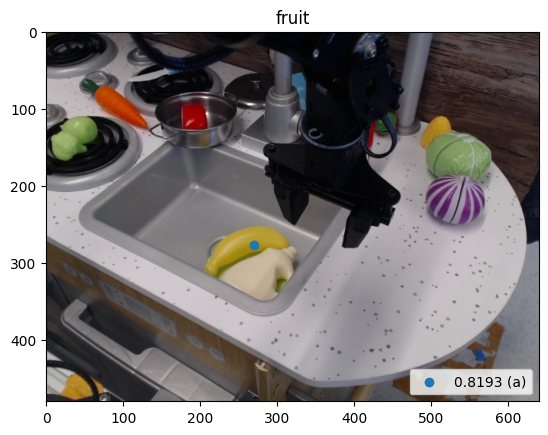


pick up glass cup


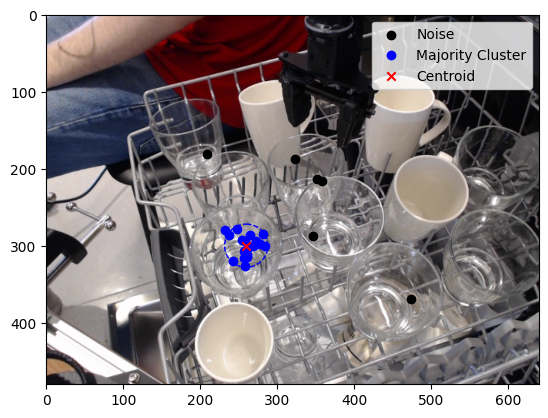

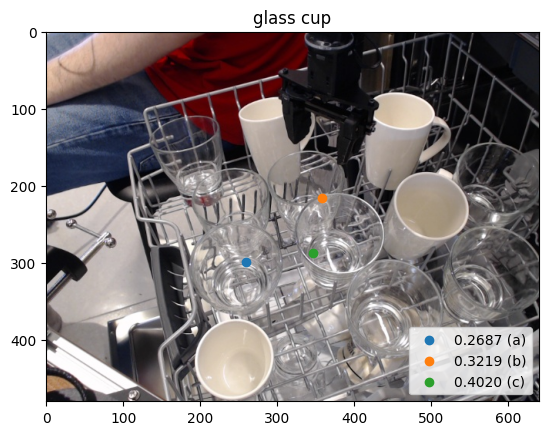


pick up red srewdriver


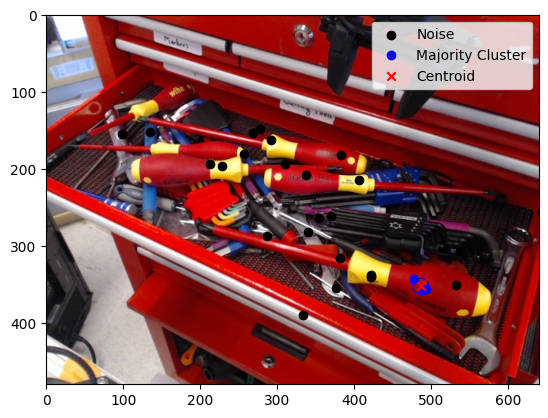

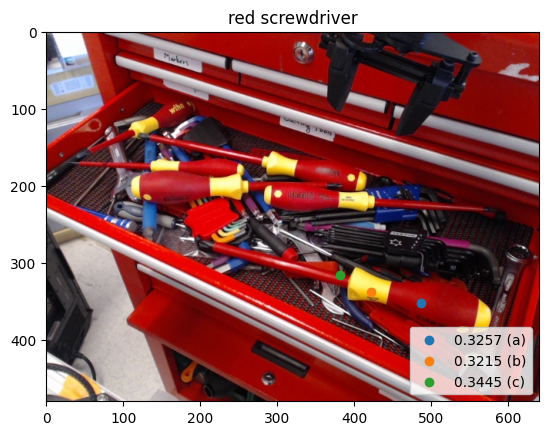


pick up the bean.


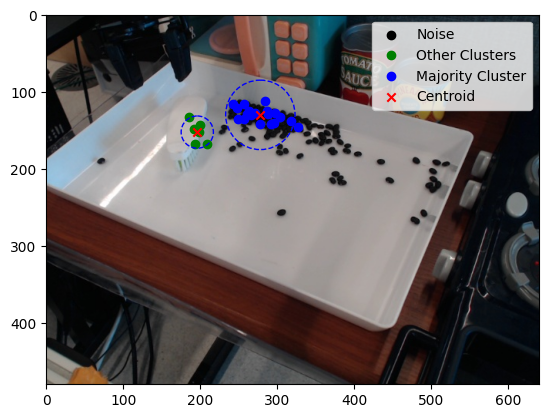

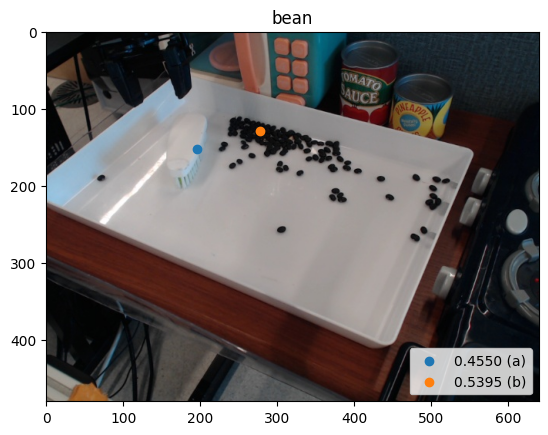


pick up the diamond.


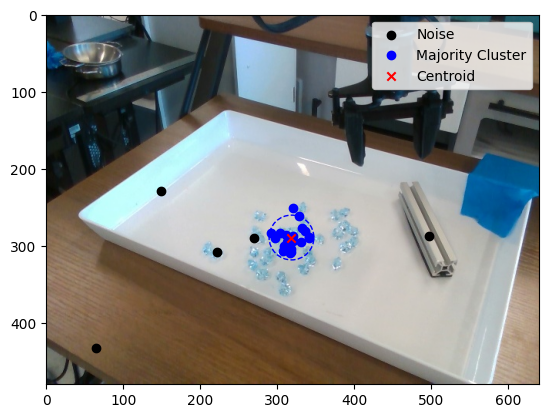

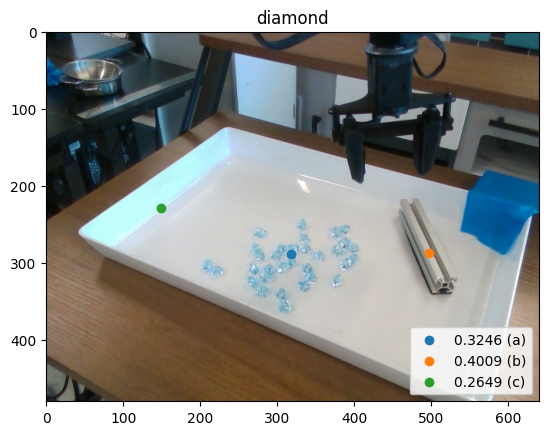


pick up vegetable and put it on the green cutting board.


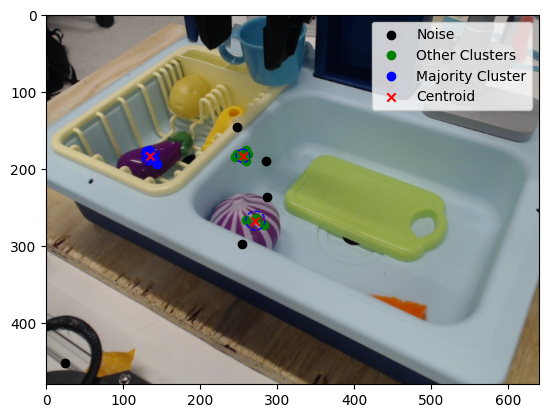

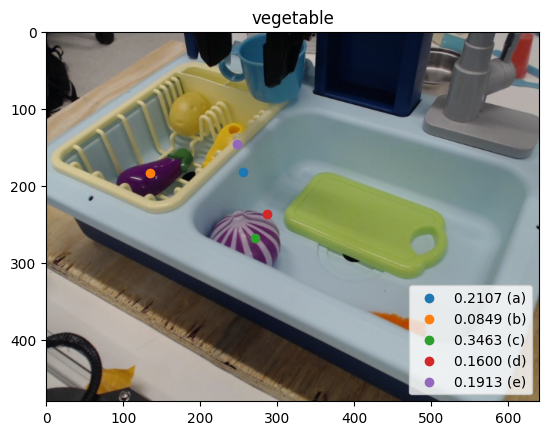


pick up cloth.


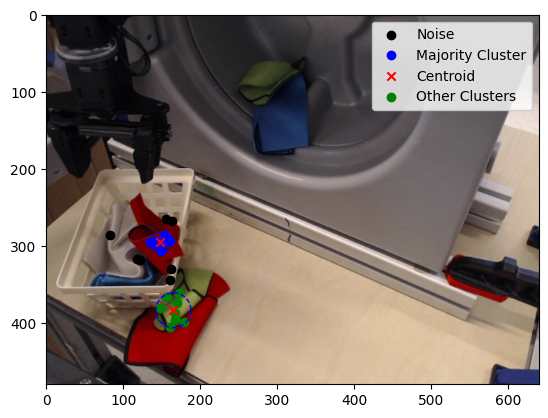

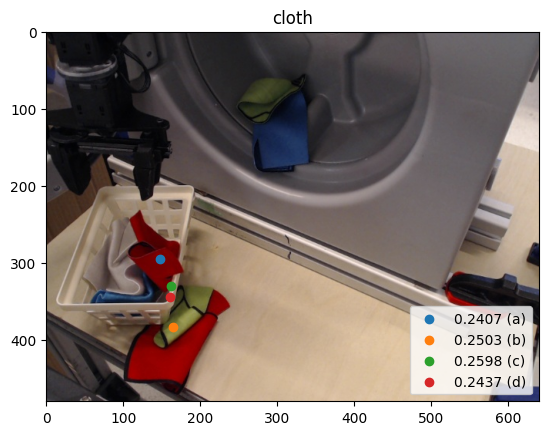


Move the can from the top left of the burner to the bottom left of the burner


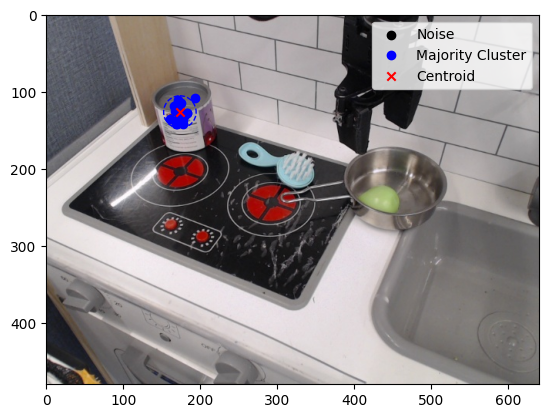

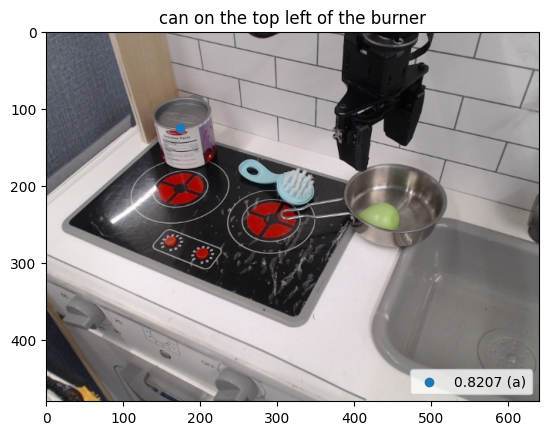


pick up vegetable from the sink and put it on the right side of the sink.


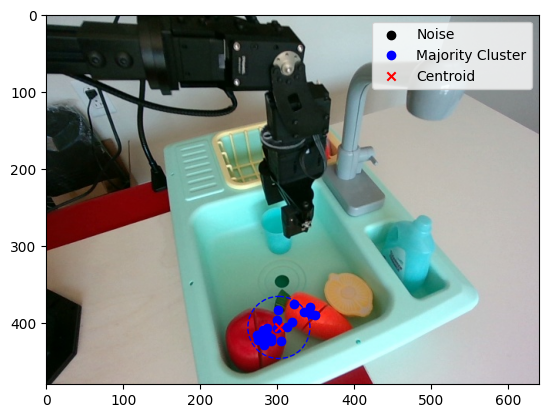

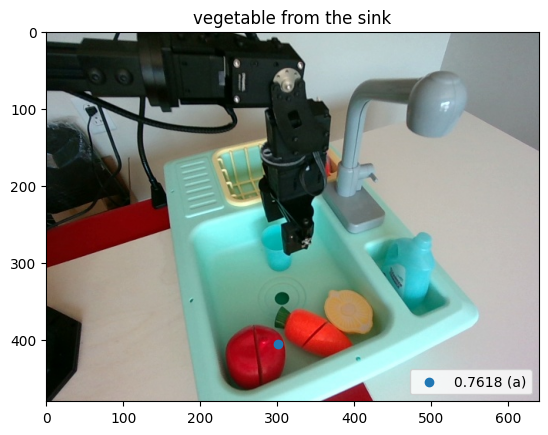


pick up the can and put it next to the tomato


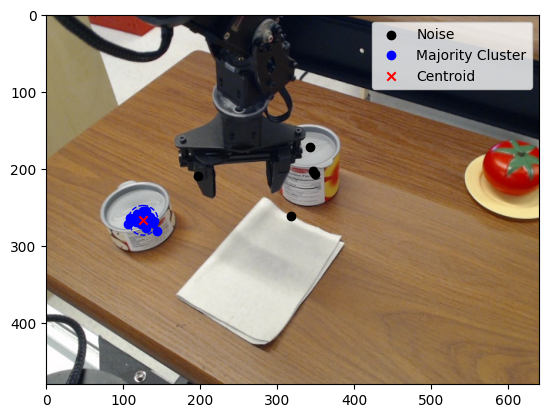

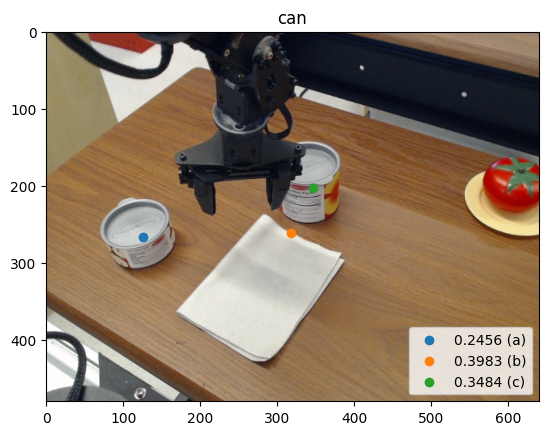

In [13]:
experiment_path = "../data/uncertain_experiments"
num_runs = 5
temperature = 0.8

epsilon = 20
min_samples = 3

prompt_starts = [
    "You are the robot in the picture. Your mission it to guide and support the user in its task to: ",
    "Your mission it to guide and support the user in its task to: ",
    "You are the robot in the picture. You have to: ",
    "You are the robot. Your mission is to: ",
    "You are the robot in the picture. Your task is to: "
    ]

#prompt_starts = ["You are the robot in the picture. Your mission it to guide and support the user in its task to: ", "You are the robot in the picture. Your mission it to guide and support the user in its task to: "]
#prompt_ends = [, "  Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the place where the object has to be moved to. Dont output anything else."]

coordinates, distances, spreads, diameters, majority_size_rates = run_experiment_vqa_with_clustering(experiment_path, prompt_starts, num_runs, temperature, epsilon, min_samples)